In [1]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import pandas as pd

from utility import get_all_files_paths
from encoder import Encoder, load_encoder
from decoder import Decoder, load_decoder
from train import train_epoch, test_epoch

In [2]:
dataset_path="data/spec/GTZAN_646"
model_save_path="models/Echoes"
csv_save_path="output/Echoes_output"
encoded_space_dim=128

os.makedirs(model_save_path, exist_ok=True)
os.makedirs(csv_save_path, exist_ok=True)

In [3]:
class AudioDataset(Dataset):
    def __init__(self, file_paths):
        self.file_paths = file_paths

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        file_path = self.file_paths[idx]
        data = np.load(file_path)
        data = data[np.newaxis, :, :]  # Add a channel dimension
        data = torch.tensor(data, dtype=torch.float32)
        
        # Extract label from file name
        filename = os.path.basename(file_path)
        label_str = filename.split('.')[0]
        label = self.label_to_index(label_str)
        
        return data, label

    @staticmethod
    def label_to_index(label_str):
        label_map = {'blues': 'blues', 'disco': 'disco', 'rock': 'rock', 'metal': 'metal', 'classical': 'classical', 'pop': 'pop', 'reggae':'reggae','country':'country', 'hiphop':'hiphop', 'jazz':'jazz'}  # Extend this as needed
        return label_map.get(label_str, -1)  # Return -1 if label is not found

genres = ['blues', 'disco', 'rock', 'metal', 'pop', 'classical', 'reggae', 'country','hiphop','jazz']

genre_file_paths = {genre: get_all_files_paths(f"{dataset_path}/{genre}", [".npy"]) for genre in genres}

train_file_paths = []
valid_file_paths = []
test_file_paths = []

for genre, paths in genre_file_paths.items():
    m = len(paths)
    test_size = int(m * 0.3)
    valid_size = int((m - test_size) * 0.1)
    train_size = m - test_size - valid_size
    
    paths = np.array(paths)
    np.random.shuffle(paths)
    
    train_paths = paths[:train_size]
    valid_paths = paths[train_size:train_size + valid_size]
    test_paths = paths[train_size + valid_size:]
    
    train_file_paths.extend(train_paths)
    valid_file_paths.extend(valid_paths)
    test_file_paths.extend(test_paths)

train_dataset = AudioDataset(train_file_paths)
valid_dataset = AudioDataset(valid_file_paths)
test_dataset = AudioDataset(test_file_paths)

batch_size = 4

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f'Training set size: {len(train_dataset)}')
print(f'Validation set size: {len(valid_dataset)}')
print(f'Test set size: {len(test_dataset)}')

Training set size: 630
Validation set size: 70
Test set size: 300


In [4]:
### Define the loss function
loss_fn = torch.nn.MSELoss()

### Define an optimizer (both for the encoder and the decoder)
lr= 0.0001

### Set the random seed for reproducible results
torch.manual_seed(0)

#model = Autoencoder(encoded_space_dim=encoded_space_dim)
encoder = Encoder(encoded_space_dim=encoded_space_dim)
decoder = Decoder(encoded_space_dim=encoded_space_dim)
params_to_optimize = [
    {'params': encoder.parameters()},
    {'params': decoder.parameters()}
]

optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=1e-05)

# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'device: {device}')

# Move both the encoder and the decoder to the selected device
encoder.to(device)
decoder.to(device)

device: cuda


Decoder(
  (decoder_lin): Sequential(
    (0): Linear(in_features=128, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.05, inplace=True)
    (2): Linear(in_features=512, out_features=167936, bias=True)
    (3): LeakyReLU(negative_slope=0.05, inplace=True)
    (4): Dropout(p=0.3, inplace=False)
  )
  (unflatten): Unflatten(dim=1, unflattened_size=(256, 16, 41))
  (decoder_conv): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 0))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.05, inplace=True)
    (3): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.05, inplace=True)
    (6): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), ou

In [5]:
num_epochs = 150
diz_loss = {'train_loss':[],'val_loss':[]}
for epoch in range(num_epochs):
	train_loss =train_epoch(encoder,decoder,device,train_loader,loss_fn,optim)
	val_loss = test_epoch(encoder,decoder,device,test_loader,loss_fn)
	print('\n EPOCH {}/{} \t train loss {} \t val loss {}'.format(epoch + 1, num_epochs,train_loss,val_loss))
	diz_loss['train_loss'].append(train_loss)
	diz_loss['val_loss'].append(val_loss)

	if (epoch+1)%10 ==0: 
		torch.save(encoder.state_dict(), f'{model_save_path}/encoder_{epoch+1}.pth')
		torch.save(decoder.state_dict(), f'{model_save_path}/decoder_{epoch+1}.pth')

	# plot_ae_outputs(encoder,decoder,n=10)


 EPOCH 1/150 	 train loss 0.18826617300510406 	 val loss 0.031391389667987823

 EPOCH 2/150 	 train loss 0.02754567563533783 	 val loss 0.020374298095703125

 EPOCH 3/150 	 train loss 0.022422978654503822 	 val loss 0.018266713246703148

 EPOCH 4/150 	 train loss 0.02079377882182598 	 val loss 0.017108004540205002

 EPOCH 5/150 	 train loss 0.0197892002761364 	 val loss 0.017013095319271088

 EPOCH 6/150 	 train loss 0.018783779814839363 	 val loss 0.016478868201375008

 EPOCH 7/150 	 train loss 0.018500808626413345 	 val loss 0.016066815704107285

 EPOCH 8/150 	 train loss 0.018066486343741417 	 val loss 0.015962673351168633

 EPOCH 9/150 	 train loss 0.017771365121006966 	 val loss 0.015945427119731903

 EPOCH 10/150 	 train loss 0.01761389710009098 	 val loss 0.015556912869215012

 EPOCH 11/150 	 train loss 0.017233731225132942 	 val loss 0.015071111731231213

 EPOCH 12/150 	 train loss 0.016717059537768364 	 val loss 0.014824669808149338

 EPOCH 13/150 	 train loss 0.0162478908896

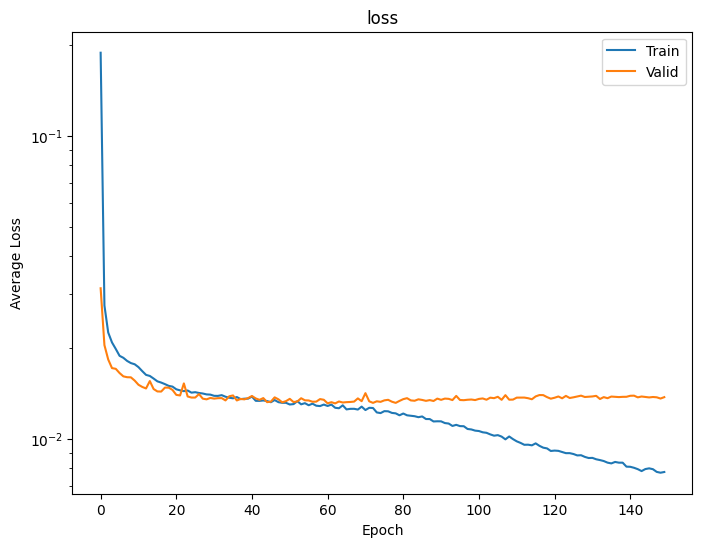

In [6]:
import matplotlib.pyplot as plt
# Plot losses
plt.figure(figsize=(8,6))
plt.semilogy(diz_loss['train_loss'], label='Train')
plt.semilogy(diz_loss['val_loss'], label='Valid')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
# plt.grid()
plt.legend()
plt.title('loss')
plt.show()

In [7]:
encoder_path=f"{model_save_path}/encoder.pth"
decoder_path=f"{model_save_path}/decoder.pth"
torch.save(encoder.state_dict(), encoder_path)
torch.save(decoder.state_dict(), decoder_path)

encoder=load_encoder(encoder_path, encoded_space_dim)
# decoder=load_decoder(decoder_path, 64)
encoder.to(device)

/home/chuangyan/Data-Side-of-the-Moon/code/encoder.py:43: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=torch.devic

Encoder(
  (encoder_cnn): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.05, inplace=True)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.05, inplace=True)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.05, inplace=True)
    (9): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (10): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): LeakyReLU(negative_slope=0.05, inplace=True)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (encoder_lin): Sequential(
    (

In [8]:
from tqdm import tqdm
encoded_samples = []
for sample in tqdm(test_dataset):
    img = sample[0].unsqueeze(0).to(device)
    label = sample[1]
    # Encode image
    encoder.eval()
    with torch.no_grad():
        encoded_img  = encoder(img)
    # Append to list
    encoded_img = encoded_img.flatten().cpu().numpy()
    encoded_sample = {f"Enc. Variable {i}": enc for i, enc in enumerate(encoded_img)}
    encoded_sample['label'] = label
    encoded_samples.append(encoded_sample)
encoded_samples = pd.DataFrame(encoded_samples)
encoded_samples.to_csv(f"{csv_save_path}/gtzan_encoded.csv", index=False)
encoded_samples

100%|██████████| 300/300 [00:00<00:00, 587.17it/s]


,Enc. Variable 0,Enc. Variable 1,Enc. Variable 2,Enc. Variable 3,Enc. Variable 4,Enc. Variable 5,Enc. Variable 6,Enc. Variable 7,Enc. Variable 8,Enc. Variable 9,...,Enc. Variable 119,Enc. Variable 120,Enc. Variable 121,Enc. Variable 122,Enc. Variable 123,Enc. Variable 124,Enc. Variable 125,Enc. Variable 126,Enc. Variable 127,label
0,2.481424,-0.605252,-0.291156,1.016386,-3.030821,-0.314150,-0.191243,-0.604524,-2.011602,-0.951327,...,-0.044434,0.612712,-0.987653,0.425655,-1.234353,-1.095704,1.163978,1.356803,1.039798,blues
1,0.693150,-0.745471,-0.402295,1.471262,-1.731827,-0.211352,1.004604,1.293203,-2.466624,-0.229025,...,0.248714,0.771622,0.078338,1.211097,-0.272069,-2.057967,1.253779,1.700436,1.036402,blues
2,1.142412,-1.598997,0.428012,0.582611,-0.155535,1.134327,0.354691,1.095741,-1.486347,-0.789132,...,1.121240,-0.683435,-0.222368,0.192973,0.014310,-1.862987,0.709424,1.017614,-0.049121,blues
3,3.677353,0.770298,0.034512,2.466090,-1.780649,-0.267466,1.050713,1.661230,-0.820081,-1.135961,...,3.258844,3.120975,0.011007,1.802735,-0.885065,0.037266,-0.095148,0.219013,-0.055034,blues
4,1.984376,-1.654491,0.140404,1.383641,-3.290249,-0.718295,0.746233,1.315479,-2.970245,-1.731053,...,0.153703,0.926331,-1.273209,1.226390,-0.966082,-1.756117,0.046433,1.209829,1.431060,blues
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,0.869808,0.327249,-1.519986,1.219347,-2.017143,0.467966,0.030001,-0.075298,-2.013830,-0.080757,...,0.223982,1.256078,0.097735,-0.505801,-1.175418,-0.357412,0.315682,0.211317,-1.484791,jazz
296,0.979179,-0.965724,-0.372020,0.425003,-1.982502,0.667961,0.311147,0.853976,-2.074630,-0.434085,...,0.671107,-0.344455,-0.039993,0.999677,0.454269,-1.831194,-0.237462,-0.178496,-0.855432,jazz
297,1.507091,-1.441202,0.234945,1.126739,-2.244188,-0.021420,-0.055858,0.020078,-0.956353,-1.015296,...,-0.077758,-0.200924,0.866796,0.809886,-0.417113,-1.940560,0.320744,0.295341,-0.885294,jazz
298,1.848914,-0.773351,-0.315471,0.986679,-2.046995,1.402094,0.793278,-0.252150,-1.165806,-1.194241,...,0.792888,0.006636,0.459632,0.507431,-0.621138,-2.146918,0.902446,1.402855,0.654017,jazz
